In [2]:
# 

In [3]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube
from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S

In [4]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [5]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

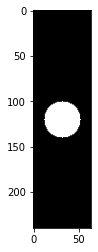

In [6]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [28]:
class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0
        #self.mu_z_    = mu_z.item()
        #self.sig_z_   = sig_z.item()
        #self.logn_ppf = lognorm.ppf([0.99], 1,
        #                    loc=self.mu_z_, scale=self.sig_z_)[0]
        
    def sample(self, x):
        b = x.shape[0]
        pz0  = dist.LogNormal(loc   = self.mu_z.view( b, 1, 1, 1, 1).expand(*x.shape),
                              scale = self.sig_z.view(b, 1, 1, 1, 1).expand(*x.shape),)
        x    = x * pz0.sample().to(x.device)
        x    = torch.clip(x, min=0, max=1)
        #x    = x / self.logn_ppf
        return x

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, z, x, y, log_bet_z, log_bet_xy, log_alpha, scale, device,
                 psf_mode:str="double_exp", apply_hill=False):
        super().__init__()
        self.log_bet_z   = log_bet_z
        self.log_bet_xy  = log_bet_xy
        self.log_alpha   = log_alpha
        self.zscale, \
        self.xscale, \
        self.yscale  = scale
        self.z       = z
        self.x       = x
        self.y       = y
        self.device  = device
        self.zd      = self.distance(z)
        self.dp      = self.gen_distance_plane(xlen=x, ylen=y)
        self.mode    = psf_mode
        bet_xy       = torch.exp(self.log_bet_xy)
        bet_z        = torch.exp(self.log_bet_z )
        alpha        = torch.exp(self.log_alpha )
        self.psf     = self.gen_psf(bet_xy, bet_z, alpha).to(device)
        self.z_pad   = (z - self.zscale + 1) // 2
        self.x_pad   = (x - self.xscale + 1) // 2
        self.y_pad   = (y - self.yscale + 1) // 2
        self.stride  = (self.zscale, self.xscale, self.yscale)
        self.apply_hill = apply_hill

    def forward(self, x):
        x_shape = x.shape
        bet_xy  = torch.exp(self.log_bet_xy)
        bet_z   = torch.exp(self.log_bet_z )
        alpha   = torch.exp(self.log_alpha )
        psf = self.gen_psf(bet_xy, bet_z, alpha).to(self.device)
        _x   = F.conv3d(input   = x                                    ,
                        weight  = psf                                  ,
                        stride  = self.stride                          ,
                        padding = (self.z_pad, self.x_pad, self.y_pad,),)
        batch = _x.shape[0]
        x = torch.empty(size=(*x_shape[:2], *_x.shape[2:])).to(self.device)
        for b in range(batch):
                x[b, 0] = _x[b, b]
        if self.apply_hill:
            log_x = torch.log(x + 1e-8)
            log_alpha_x_k = 0.5 * (self.log_alpha - log_x) #k = 0.5
            alpha_x_k = torch.exp(log_alpha_x_k)
            denom = torch.log(1. + alpha_x_k)
            x = torch.exp( - denom)
        return x

    def gen_psf(self, bet_xy, bet_z, alpha):
        if bet_xy.shape:
            b = bet_xy.shape[0]
        else:
            b = 1
        if self.mode == "student_t":
            psf_lateral = self.gen_2dstudent_t(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dstudent_t(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
        if self.mode == "gumbel":
            psf_lateral = self.gen_2dgumbel(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dgumbel(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
            if not alpha.shape:
                alpha = alpha.unsqueeze(0)
            psf = self.gen_double_exp_dist(psf, alpha[:, None, None, None, None],)
        if self.mode == "weibull":
            psf_lateral = self.gen_2dweibull(self.dp, bet_xy, b, alpha)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dweibull(self.zd, bet_z , b, alpha)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
        if self.mode == "gaussian":
            psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial)) # log-sum-exp technique
        if self.mode == "double_exp":
            psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
            if not alpha.shape:
                alpha = alpha.unsqueeze(0)
            psf = self.gen_double_exp_dist(psf, alpha[:, None, None, None, None],)
        psf = psf / torch.sum(psf)
        return psf

    def _init_distance(self, length):
        return torch.zeros(length)

    def _distance_from_center(self, index, length):
        return abs(index - length // 2)

    def distance(self, length):
        distance = torch.zeros(length)
        for idx in range(length):
            distance[idx] = self._distance_from_center(idx, length)
        return distance.to(self.device)

    def gen_distance_plane(self, xlen, ylen):
        xd = self.distance(xlen)
        yd = self.distance(ylen)
        xp = xd.expand(ylen, xlen)
        yp = yd.expand(xlen, ylen).transpose(1, 0)
        dp = xp ** 2 + yp ** 2
        return dp.to(self.device)

    def gen_2dnorm(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane / bet_xy ** 2
        normterm = (torch.pi * 2) * (bet_xy ** 2)
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_1dnorm(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance ** 2 / bet_z ** 2
        normterm = (torch.pi * 2) ** 0.5 * bet_z
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm
    
    def gen_2dgumbel(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane**0.5 / bet_xy
        norm     = torch.exp(-d_2)
        return norm

    def gen_1dgumbel(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance / bet_z
        norm     = torch.exp(-d_2)
        return norm
    ##
    def gen_2dweibull(self, distance_plane, bet_xy, b, alpha):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane**0.5 / bet_xy
        norm     = - d_2 ** alpha
        return norm
    ##
    def gen_1dweibull(self, distance, bet_z, b, alpha):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance / bet_z
        norm     = - d_2 ** alpha
        return norm

    def gen_2dstudent_t(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  (distance_plane / bet_xy + 1) ** -((bet_xy + 1) / 2)
        normterm = torch.exp(S.gammaln((bet_xy + 1) / 2) - S.gammaln(bet_xy / 2)) / (torch.pi * bet_xy) ** 0.5
        norm     = normterm * d_2 
        return norm

    def gen_1dstudent_t(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  (distance ** 2 / bet_z + 1) ** -((bet_z + 1) / 2)
        normterm = torch.exp(S.gammaln((bet_z + 1) / 2) - S.gammaln(bet_z / 2)) / (torch.pi * bet_z) ** 0.5
        norm     = normterm * d_2 
        return norm

    def gen_double_exp_dist(self, norm, alpha,):
        pdf  = 1. - torch.exp(-alpha * norm)
        return pdf


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x
    
    def sample(self, x):
        b = x.shape[0]
        px = dist.Normal(loc   = x           ,
                         scale = self.sig_eps.view(b, 1, 1, 1, 1).expand(*x.shape).to(x.device))
        x  = px.rsample()
        x  = torch.clip(x, min=0, max=1)
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train",dist="double_exp", apply_hill=False):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z   = torch.tensor(params["mu_z"])
            self.sig_z  = torch.tensor(params["sig_z"])
            self.log_ez0 = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
            self.log_bet_z  = nn.Parameter(torch.tensor(params["log_bet_z" ]).to(device), requires_grad=True)
            self.log_bet_xy = nn.Parameter(torch.tensor(params["log_bet_xy"]).to(device), requires_grad=True)
            self.log_alpha  = nn.Parameter(torch.tensor(params["log_alpha" ]).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
            self.log_bet_z   = nn.Parameter(torch.tensor(params["log_bet_z" ]), requires_grad=False)
            self.log_bet_xy  = nn.Parameter(torch.tensor(params["log_bet_xy"]), requires_grad=False)
            self.log_alpha   = nn.Parameter(torch.tensor(params["log_alpha" ]), requires_grad=False)
        else:
            raise(NotImplementedError())
        scale = [params["scale"], 1, 1]
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(z           = z              ,
                               x           = x              ,
                               y           = y              ,
                               log_bet_z   = self.log_bet_z ,
                               log_bet_xy  = self.log_bet_xy,
                               log_alpha   = self.log_alpha ,
                               scale       = scale          ,
                               device      = device         ,
                               psf_mode    = dist           ,
                               apply_hill  = apply_hill     ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)

    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x

    def sample(self, x):
        x = self.emission.sample(x)
        x = self.blur(x)
        x = self.noise.sample(x)
        x = self.preprocess(x)
        return x
    
    def sample_from_params(self, x, params):
        if isinstance(params["scale"], torch.Tensor):
            z = int(params["scale"][0])
        else:
            z = params["scale"]
        scale = [z, 1, 1] ## use only one scale
        emission   = Emission(tt(params["mu_z"]), tt(params["sig_z"]))
        blur       = Blur(self.z, self.x, self.y,
                          tt(params["log_bet_z"]), tt(params["log_bet_xy"]),
                          tt(params["log_alpha"]), scale, self.device)
        noise      = Noise(tt(params["sig_eps"]))
        preprocess = PreProcess(min=self.postmin, max=self.postmax)
        x = emission.sample(x)
        x = blur(x)
        x = noise.sample(x)
        x = preprocess(x)
        return x

In [9]:
dirpath = "_beads_roi_extracted"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
beadslist
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

In [25]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        log_ez0, bet_z, bet_xy, alpha = [i for i in model.parameters()]
        print(f'epoch {_}, loss {loss:.8f}, log_ez0 {log_ez0.item():.6f}, log_bet_xy {bet_xy.item():.6f}, log_bet_z {bet_z.item():.6f}, log_alpha {alpha.item():.6f}')if _ % 10 == 0 else 0
    return loss.item()

# gumbel
## no clip

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(2.).item(),
          "log_bet_xy" : np.log(5.).item(),
          "log_alpha"  : np.log(2.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gumbel"         ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00524741, log_ez0 0.210000, log_bet_xy 1.619434, log_bet_z 0.703147, log_alpha 0.703146
epoch 10, loss 0.00509222, log_ez0 0.108306, log_bet_xy 1.719915, log_bet_z 0.803838, log_alpha 0.804124
epoch 20, loss 0.00486624, log_ez0 -0.000662, log_bet_xy 1.821817, log_bet_z 0.907099, log_alpha 0.908487
epoch 30, loss 0.00454178, log_ez0 -0.117544, log_bet_xy 1.921610, log_bet_z 1.011458, log_alpha 1.014142
epoch 40, loss 0.00441872, log_ez0 -0.196497, log_bet_xy 2.013157, log_bet_z 1.110092, log_alpha 1.115739
epoch 50, loss 0.00433824, log_ez0 -0.208925, log_bet_xy 2.097829, log_bet_z 1.203516, log_alpha 1.214891
epoch 60, loss 0.00422275, log_ez0 -0.174250, log_bet_xy 2.182429, log_bet_z 1.298175, log_alpha 1.318883
epoch 70, loss 0.00407122, log_ez0 -0.121948, log_bet_xy 2.273810, log_bet_z 1.400899, log_alpha 1.435010
epoch 80, loss 0.00388340, log_ez0 -0.069113, log_bet_xy 2.375291, log_bet_z 1.515180, log_alpha 1.566324
epoch 90, loss 0.00365127, log_e

[0.003402926027774811,
 0.009124490432441235,
 0.0074224090203642845,
 0.0031015374697744846,
 0.0036865114234387875,
 0.006354523357003927,
 0.0025527048856019974,
 0.0022047413513064384,
 0.004240420181304216,
 0.0038558868691325188,
 0.002919393125921488]

In [ ]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# gumbel
## clip

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(2.).item(),
          "log_bet_xy" : np.log(5.).item(),
          "log_alpha"  : np.log(2.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gumbel"         ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00355543, log_ez0 0.210000, log_bet_xy 1.619433, log_bet_z 0.703147, log_alpha 0.703146
epoch 10, loss 0.00337595, log_ez0 0.108475, log_bet_xy 1.720040, log_bet_z 0.803947, log_alpha 0.804229
epoch 20, loss 0.00311159, log_ez0 0.000279, log_bet_xy 1.822535, log_bet_z 0.907758, log_alpha 0.909081
epoch 30, loss 0.00271636, log_ez0 -0.117169, log_bet_xy 1.923294, log_bet_z 1.013157, log_alpha 1.015537
epoch 40, loss 0.00254559, log_ez0 -0.207791, log_bet_xy 2.015381, log_bet_z 1.112406, log_alpha 1.117487
epoch 50, loss 0.00247028, log_ez0 -0.247793, log_bet_xy 2.098589, log_bet_z 1.204325, log_alpha 1.214789
epoch 60, loss 0.00239323, log_ez0 -0.243338, log_bet_xy 2.177578, log_bet_z 1.293104, log_alpha 1.312219
epoch 70, loss 0.00229163, log_ez0 -0.211967, log_bet_xy 2.258021, log_bet_z 1.384340, log_alpha 1.415899
epoch 80, loss 0.00216412, log_ez0 -0.168436, log_bet_xy 2.344058, log_bet_z 1.482352, log_alpha 1.530345
epoch 90, loss 0.00201186, log_ez

[0.0018534755799919367,
 0.006496690213680267,
 0.004870764445513487,
 0.0017303479835391045,
 0.002227520104497671,
 0.0032242487650364637,
 0.0011985216988250613,
 0.0008814820903353393,
 0.0022793738171458244,
 0.0023074960336089134,
 0.0014852940803393722]

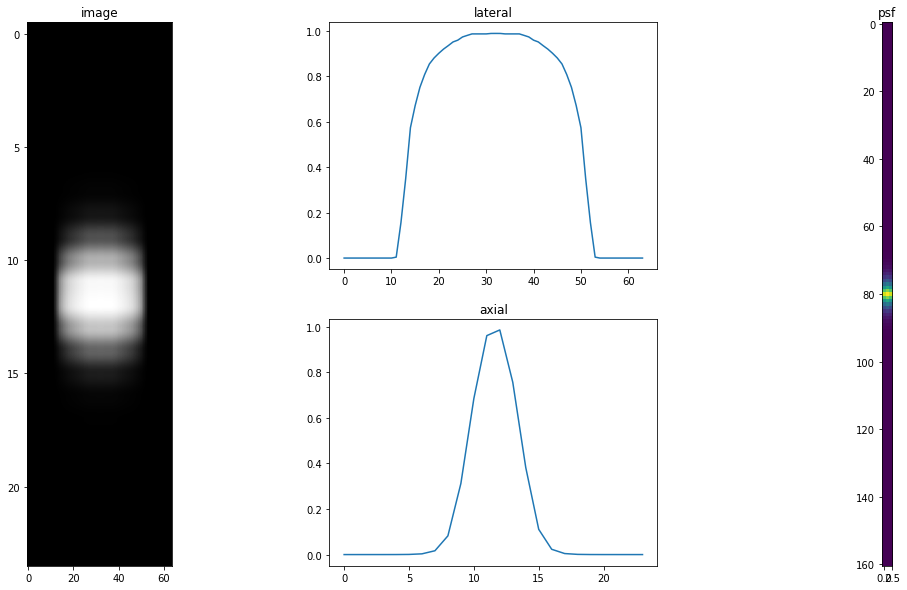

In [15]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# weibull
## abandoned for now

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "weibull"        ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)

beads_001_roi000


/home/haruhiko/Documents/JNet/env/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in ConvolutionBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/haruhiko/Documents/JNet/env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/haruhiko/Documents/JNet/env/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/haruhiko/Documents/JNet/env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/haruhiko/Documents/JNet/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/u

RuntimeError: Function 'ConvolutionBackward0' returned nan values in its 0th output.

# gaussian
## clipped

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gaussian"       ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00108364, log_ez0 0.230000, log_bet_xy 0.009990, log_bet_z 3.005731, log_alpha 0.000000
epoch 10, loss 0.00103680, log_ez0 0.322905, log_bet_xy 0.109623, log_bet_z 3.091523, log_alpha 0.000000
epoch 20, loss 0.00103745, log_ez0 0.362090, log_bet_xy 0.207625, log_bet_z 3.126868, log_alpha 0.000000
epoch 30, loss 0.00103413, log_ez0 0.340605, log_bet_xy 0.299970, log_bet_z 3.105964, log_alpha 0.000000
epoch 40, loss 0.00103367, log_ez0 0.324432, log_bet_xy 0.382663, log_bet_z 3.091347, log_alpha 0.000000
epoch 50, loss 0.00103293, log_ez0 0.333497, log_bet_xy 0.455935, log_bet_z 3.100047, log_alpha 0.000000
epoch 60, loss 0.00103268, log_ez0 0.338669, log_bet_xy 0.522236, log_bet_z 3.104571, log_alpha 0.000000
epoch 70, loss 0.00103239, log_ez0 0.334163, log_bet_xy 0.582916, log_bet_z 3.100408, log_alpha 0.000000
epoch 80, loss 0.00103220, log_ez0 0.334007, log_bet_xy 0.638575, log_bet_z 3.100246, log_alpha 0.000000
epoch 90, loss 0.00103205, log_ez0 0.33

[0.0010319281136617064,
 0.005685820709913969,
 0.0039505381137132645,
 0.0009091889369301498,
 0.0012319398811087012,
 0.0014028761070221663,
 0.0005297746392898262,
 0.00023247765784617513,
 0.0013996418565511703,
 0.001029826933518052,
 0.0004153932386543602]

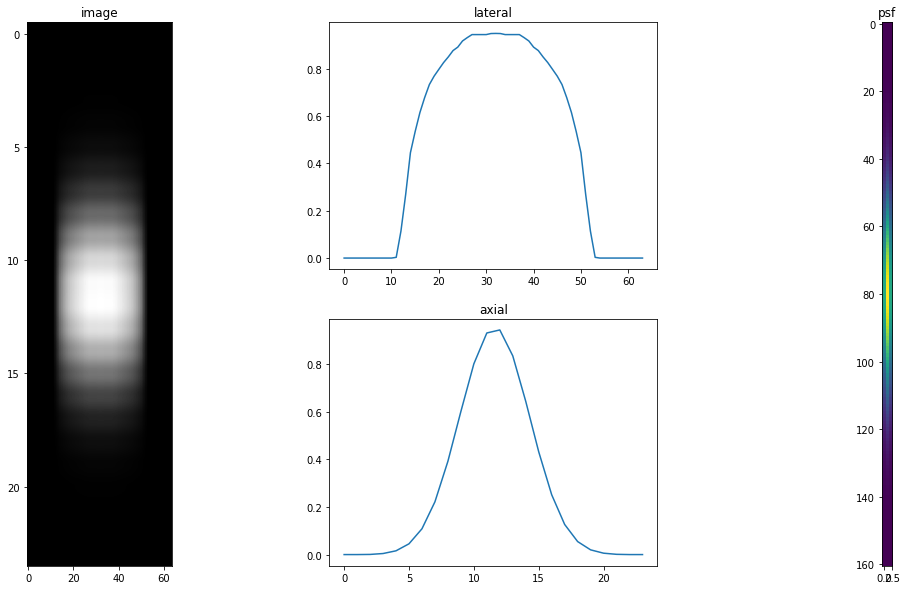

In [26]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# gaussian
## no clipped

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gaussian"       ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00244447, log_ez0 0.230000, log_bet_xy 0.009991, log_bet_z 3.005732, log_alpha 0.000000
epoch 10, loss 0.00225142, log_ez0 0.328771, log_bet_xy 0.109578, log_bet_z 3.104717, log_alpha 0.000000
epoch 20, loss 0.00212257, log_ez0 0.420201, log_bet_xy 0.207685, log_bet_z 3.197527, log_alpha 0.000000
epoch 30, loss 0.00206350, log_ez0 0.493923, log_bet_xy 0.303025, log_bet_z 3.274925, log_alpha 0.000000
epoch 40, loss 0.00205195, log_ez0 0.539195, log_bet_xy 0.394041, log_bet_z 3.325104, log_alpha 0.000000
epoch 50, loss 0.00205318, log_ez0 0.554058, log_bet_xy 0.478906, log_bet_z 3.342193, log_alpha 0.000000
epoch 60, loss 0.00205206, log_ez0 0.549056, log_bet_xy 0.556178, log_bet_z 3.336048, log_alpha 0.000000
epoch 70, loss 0.00205062, log_ez0 0.538607, log_bet_xy 0.625497, log_bet_z 3.324555, log_alpha 0.000000
epoch 80, loss 0.00205025, log_ez0 0.532409, log_bet_xy 0.687564, log_bet_z 3.317602, log_alpha 0.000000
epoch 90, loss 0.00205006, log_ez0 0.53

[0.002049855887889862,
 0.007775507401674986,
 0.006032835692167282,
 0.0017768337856978178,
 0.0021574432030320168,
 0.003523766528815031,
 0.0013617158401757479,
 0.0008467279840260744,
 0.0027026308234781027,
 0.0019248358439654112,
 0.0012248916318640113]

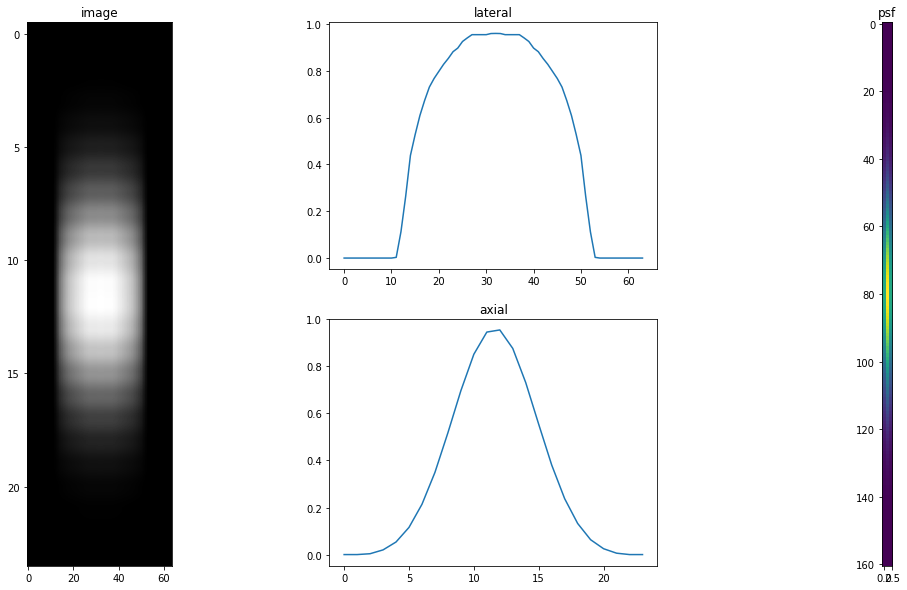

In [28]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# gaussian + hill
## no clip

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gaussian"       ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00239971, log_ez0 0.230000, log_bet_xy 0.009997, log_bet_z 2.985733, log_alpha -0.010000
epoch 10, loss 0.00222561, log_ez0 0.329443, log_bet_xy 0.108849, log_bet_z 2.892039, log_alpha -0.109444
epoch 20, loss 0.00209502, log_ez0 0.425937, log_bet_xy 0.202891, log_bet_z 2.834647, log_alpha -0.205948
epoch 30, loss 0.00199821, log_ez0 0.515741, log_bet_xy 0.289461, log_bet_z 2.816213, log_alpha -0.295781
epoch 40, loss 0.00193274, log_ez0 0.594612, log_bet_xy 0.367617, log_bet_z 2.791317, log_alpha -0.374717
epoch 50, loss 0.00189166, log_ez0 0.660581, log_bet_xy 0.437442, log_bet_z 2.754740, log_alpha -0.440800
epoch 60, loss 0.00186793, log_ez0 0.713914, log_bet_xy 0.499655, log_bet_z 2.730883, log_alpha -0.494303
epoch 70, loss 0.00185565, log_ez0 0.754890, log_bet_xy 0.555381, log_bet_z 2.714426, log_alpha -0.535512
epoch 80, loss 0.00184960, log_ez0 0.784608, log_bet_xy 0.605763, log_bet_z 2.698446, log_alpha -0.565527
epoch 90, loss 0.00184691, log

[0.001845839200541377,
 0.007605709135532379,
 0.005898922681808472,
 0.001605520723387599,
 0.0019660310354083776,
 0.0031903597991913557,
 0.0012372032506391406,
 0.0007058666087687016,
 0.002612926997244358,
 0.001695707207545638,
 0.001100911758840084]

# gaussian + hill
## clip

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "gaussian"       ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00151271, log_ez0 0.230000, log_bet_xy 0.009994, log_bet_z 2.985732, log_alpha -0.010000
epoch 10, loss 0.00134186, log_ez0 0.328373, log_bet_xy 0.108633, log_bet_z 2.886317, log_alpha -0.108373
epoch 20, loss 0.00120932, log_ez0 0.418489, log_bet_xy 0.201536, log_bet_z 2.790032, log_alpha -0.198498
epoch 30, loss 0.00111580, log_ez0 0.493514, log_bet_xy 0.285193, log_bet_z 2.700399, log_alpha -0.273556
epoch 40, loss 0.00105577, log_ez0 0.551021, log_bet_xy 0.358339, log_bet_z 2.621172, log_alpha -0.331131
epoch 50, loss 0.00102109, log_ez0 0.593725, log_bet_xy 0.421605, log_bet_z 2.555414, log_alpha -0.373940
epoch 60, loss 0.00100317, log_ez0 0.625948, log_bet_xy 0.476574, log_bet_z 2.504490, log_alpha -0.406299
epoch 70, loss 0.00099494, log_ez0 0.650248, log_bet_xy 0.524969, log_bet_z 2.467687, log_alpha -0.430762
epoch 80, loss 0.00099161, log_ez0 0.667381, log_bet_xy 0.568287, log_bet_z 2.442787, log_alpha -0.448086
epoch 90, loss 0.00099044, log

[0.0009900894947350025,
 0.0056747994385659695,
 0.003974938299506903,
 0.0008956108940765262,
 0.00120833539403975,
 0.0013720893766731024,
 0.0005453430349007249,
 0.00022843816259410232,
 0.0014575757086277008,
 0.0009651543805375695,
 0.00045749088167212903]

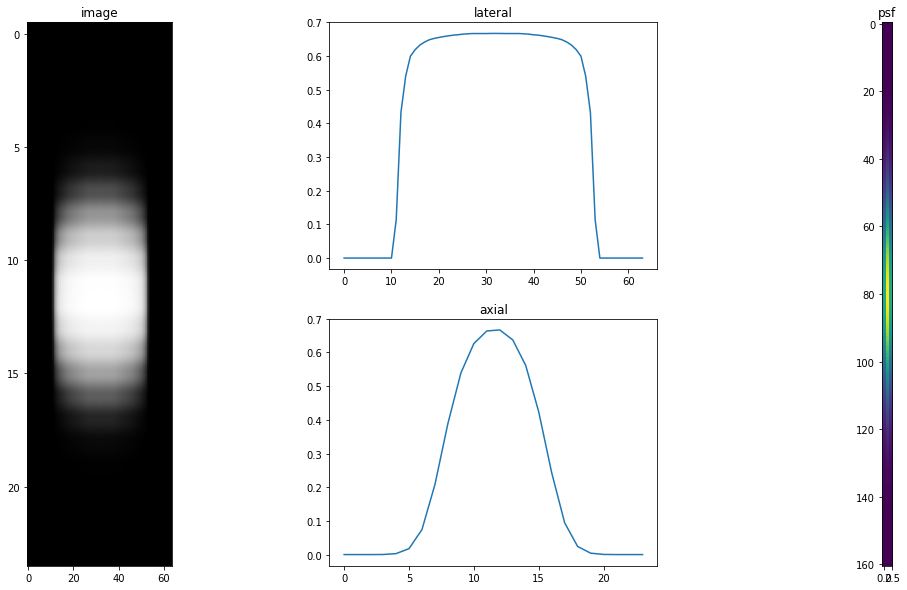

In [31]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# student_t with hill
## no clip

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    #label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00491869, log_ez0 0.230000, log_bet_xy 0.009924, log_bet_z 2.985736, log_alpha -0.010000
epoch 10, loss 0.00483418, log_ez0 0.329355, log_bet_xy 0.108564, log_bet_z 2.884895, log_alpha -0.109359
epoch 20, loss 0.00476180, log_ez0 0.425639, log_bet_xy 0.204421, log_bet_z 2.780142, log_alpha -0.205667
epoch 30, loss 0.00470208, log_ez0 0.516303, log_bet_xy 0.295305, log_bet_z 2.668672, log_alpha -0.296407
epoch 40, loss 0.00465270, log_ez0 0.599473, log_bet_xy 0.379657, log_bet_z 2.548440, log_alpha -0.379725
epoch 50, loss 0.00461048, log_ez0 0.674201, log_bet_xy 0.456694, log_bet_z 2.418036, log_alpha -0.454692
epoch 60, loss 0.00457103, log_ez0 0.740488, log_bet_xy 0.526291, log_bet_z 2.276453, log_alpha -0.521320
epoch 70, loss 0.00452917, log_ez0 0.799230, log_bet_xy 0.588769, log_bet_z 2.122910, log_alpha -0.580498
epoch 80, loss 0.00447779, log_ez0 0.852170, log_bet_xy 0.644646, log_bet_z 1.956834, log_alpha -0.633944
epoch 90, loss 0.00440687, log

[0.0043141478672623634,
 0.009908380918204784,
 0.009048547595739365,
 0.004039950203150511,
 0.005063098855316639,
 0.007450112607330084,
 0.0032542203553020954,
 0.0026984787546098232,
 0.006025707349181175,
 0.005738450214266777,
 0.004352755844593048]

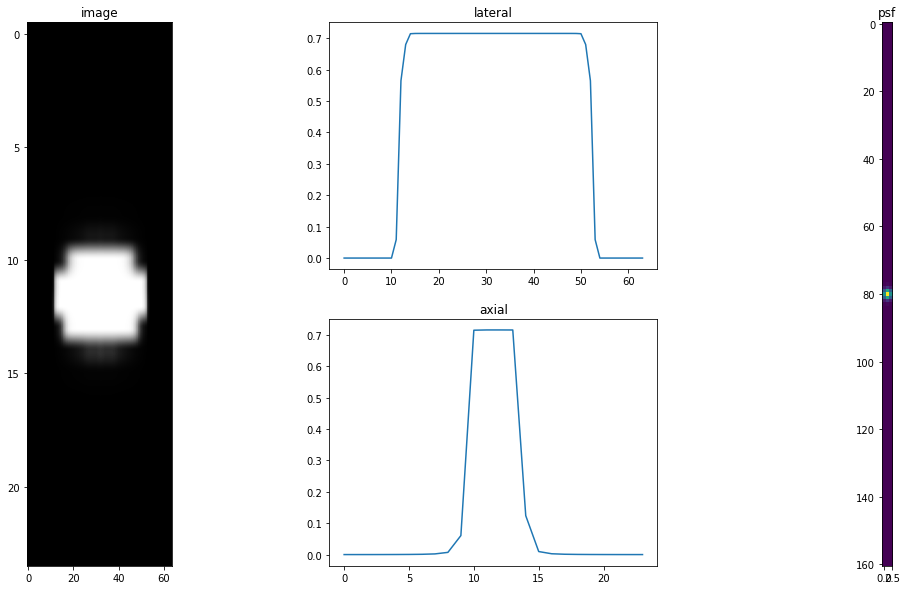

In [33]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()

# student_t hill
## clipped

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(1.).item(),
          "log_alpha"  : np.log(1.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          apply_hill   = True             ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00293359, log_ez0 0.230000, log_bet_xy 0.009898, log_bet_z 2.985736, log_alpha -0.010000
epoch 10, loss 0.00287132, log_ez0 0.329090, log_bet_xy 0.108150, log_bet_z 2.884902, log_alpha -0.109092
epoch 20, loss 0.00282161, log_ez0 0.423742, log_bet_xy 0.203055, log_bet_z 2.780178, log_alpha -0.203755
epoch 30, loss 0.00278384, log_ez0 0.510072, log_bet_xy 0.292012, log_bet_z 2.668809, log_alpha -0.290128
epoch 40, loss 0.00275548, log_ez0 0.585157, log_bet_xy 0.373281, log_bet_z 2.548847, log_alpha -0.365298
epoch 50, loss 0.00273253, log_ez0 0.647635, log_bet_xy 0.446177, log_bet_z 2.419037, log_alpha -0.427910
epoch 60, loss 0.00271071, log_ez0 0.697879, log_bet_xy 0.510916, log_bet_z 2.278548, log_alpha -0.478339
epoch 70, loss 0.00268554, log_ez0 0.737796, log_bet_xy 0.568244, log_bet_z 2.126772, log_alpha -0.518474
epoch 80, loss 0.00265210, log_ez0 0.770444, log_bet_xy 0.619024, log_bet_z 1.963280, log_alpha -0.551353
epoch 90, loss 0.00260411, log

[0.002541194437071681,
 0.007097230758517981,
 0.006076708436012268,
 0.0024419445544481277,
 0.0032932180911302567,
 0.0040704645216465,
 0.0017279461026191711,
 0.0012746243737637997,
 0.0038159280084073544,
 0.0038000461645424366,
 0.0025866420473903418]

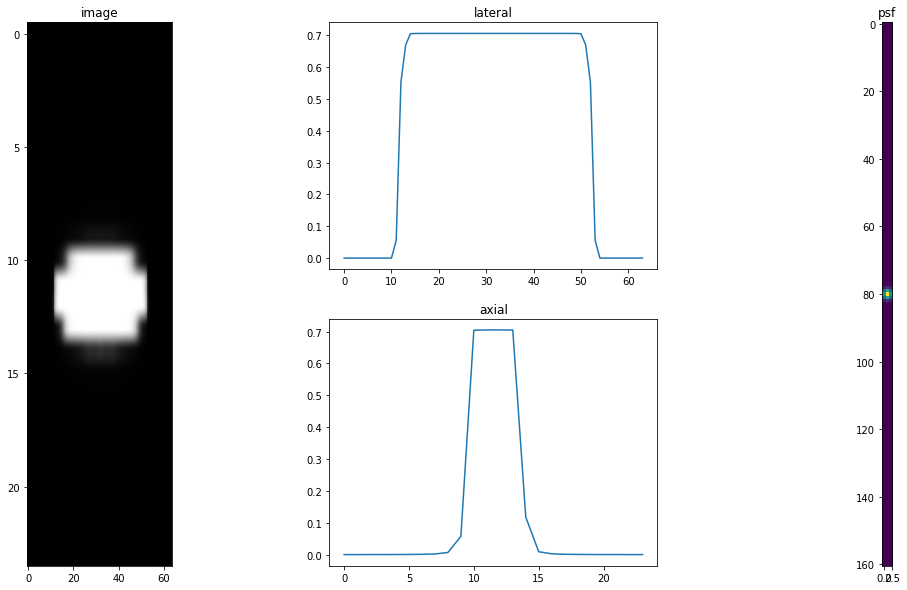

In [35]:
x = data.to(device).unsqueeze(0)
x = blur(x).squeeze(0)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[12])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 1, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()